In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.ML.Cluster import Butina

from matplotlib_venn import venn3
import networkx as nx

In [2]:
import sys
sys.path.append('../../code')

import min_vertex_k_cut

In [3]:
raw = pd.read_csv('../../data/raw/ADME_public_set_3521.csv')
raw = raw.dropna(subset=['LOG SOLUBILITY PH 6.8 (ug/mL)'])
solubility = np.array(raw['LOG SOLUBILITY PH 6.8 (ug/mL)'].to_list())
solubility = solubility < 1.0
smiles = raw['SMILES'].to_list()

In [4]:
data = pd.DataFrame({
    'smiles': smiles,
    'value': solubility
})
data

,smiles,value
0,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,True
1,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,True
2,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,False
3,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,False
4,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,True
...,...,...
2168,Cc1cc(C)cc(C(=O)NCCCNc2ncccn2)c1,False
2169,CCc1noc(COc2c(C)ccnc2Cl)n1,False
2170,CC(C)(C)Cc1nnc(-c2cnc3onc(C4CCCC4)c3c2)o1,True
2171,Cc1nonc1C(=O)NCCc1c[nH]c2cccc(C3(O)CCOCC3)c12,False


In [5]:
smiles = data['smiles'].to_list()
threshold = 0.4

neighborhood_graph = min_vertex_k_cut.get_neighborhood_graph(smiles, threshold)
main_component, small_components = min_vertex_k_cut.get_main_component(neighborhood_graph)

old_nodes_to_new = dict(zip(main_component.nodes(), range(main_component.number_of_nodes())))
new_nodes_to_old = {v: k for k, v in old_nodes_to_new.items()}
main_component = nx.relabel_nodes(main_component, old_nodes_to_new)

In [6]:
for coarse_threhold in [0.90, 0.80, 0.70, 0.60, 0.50, 0.40]:
    coarsed_main_component, _ = min_vertex_k_cut.coarse_graph(main_component, coarse_threhold)
    node_degrees = list(dict(coarsed_main_component.degree()).values())
    print(coarse_threhold, len(coarsed_main_component), np.mean(node_degrees))

0.9 599 6.504173622704507
0.8 581 6.209982788296041
0.7 558 5.810035842293907
0.6 507 4.986193293885601
0.5 399 4.516290726817043
0.4 203 4.354679802955665


In [7]:
coarsed_main_component, node_to_cluster = min_vertex_k_cut.coarse_graph(main_component, 0.9)

In [8]:
model = min_vertex_k_cut.trisect_connected_graph(coarsed_main_component, part_min_frac=0.20, emphasis=1, max_mip_gap=0.02)

Total molecules: 599
Min size of a partition: 119
Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 10493 (-1797) rows, 1797 (0) columns and 23376 (-3594) elements
Clp0014I Perturbing problem by 0.001% of 1.0288039 - largest nonzero change 9.9998062e-05 ( 0.0099998062%) - largest zero change 0
Clp0000I Optimal - objective value 599
Coin0511I After Postsolve, objective 599, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 599 - 2511 iterations time 0.092, Presolve 0.00, Idiot 0.02

Starting MIP optimization
Cgl0003I 0 fixed, 0 tightened bounds, 7862 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1909 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 120 strengthened rows, 0 substitutions
Cgl0004I processed model has 8247 rows, 1797 columns (1797 integer (1797 of which binary)) and 26529 elemen

In [9]:
split = min_vertex_k_cut.process_trisect_results(model, coarsed_main_component, main_component, node_to_cluster)

[ 10 119 120 350]


In [10]:
first_idx = []
second_idx = []
third_idx = []

for S_idx, partition in enumerate(split):
    G_idx = new_nodes_to_old[S_idx]
    if partition == 0:
        first_idx.append(G_idx)
    if partition == 1:
        second_idx.append(G_idx)
    if partition == 2:
        third_idx.append(G_idx)

In [11]:
for component in small_components:
    i = np.argmin([len(first_idx), len(second_idx), len(third_idx)])
    if i == 0:
        first_idx.extend(component)
    if i == 1:
        second_idx.extend(component)
    if i == 2:
        third_idx.extend(component)

In [12]:
[len(first_idx), len(second_idx), len(third_idx)]

[721, 721, 721]

In [14]:
part_first = data.iloc[first_idx]
part_second = data.iloc[second_idx]
part_third = data.iloc[third_idx]


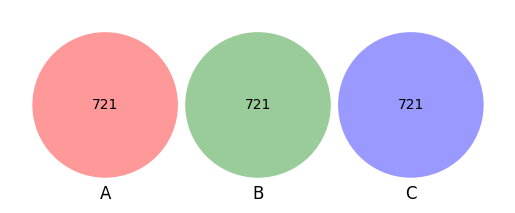

In [15]:
venn3([
    set(part_first['smiles'].tolist()),
    set(part_second['smiles'].tolist()),
    set(part_third['smiles'].tolist()),
])

In [16]:
train_1 = pd.concat([part_first, part_second])
test_1 = part_third.copy()

train_2 = pd.concat([part_first, part_third])
test_2 = part_second.copy()

train_3 = pd.concat([part_second, part_third])
test_3 = part_first.copy()

In [17]:
min_vertex_k_cut.test_split(train_1['smiles'], test_1['smiles'], threshold=0.4)
min_vertex_k_cut.test_split(train_2['smiles'], test_2['smiles'], threshold=0.4)
min_vertex_k_cut.test_split(train_3['smiles'], test_3['smiles'], threshold=0.4)

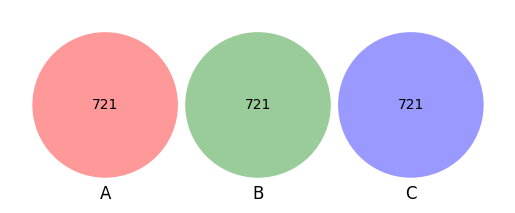

In [18]:
venn3([
    set(test_1['smiles'].tolist()),
    set(test_2['smiles'].tolist()),
    set(test_3['smiles'].tolist()),
])

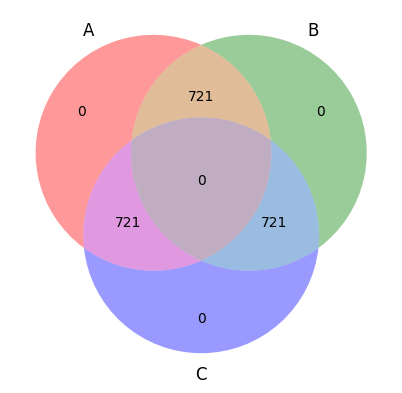

In [19]:
venn3([
    set(train_1['smiles'].tolist()),
    set(train_2['smiles'].tolist()),
    set(train_3['smiles'].tolist()),
])

In [20]:
train_1.to_csv('../../data/hi/sol/train_1.csv')
train_2.to_csv('../../data/hi/sol/train_2.csv')
train_3.to_csv('../../data/hi/sol/train_3.csv')

In [21]:
test_1.to_csv('../../data/hi/sol/test_1.csv')
test_2.to_csv('../../data/hi/sol/test_2.csv')
test_3.to_csv('../../data/hi/sol/test_3.csv')